In [1]:
%matplotlib inline

import anacal
import galsim
import matplotlib.pylab as plt

In [2]:
npix = 64
pixel_scale = 0.2  # LSST image pixel scale
# noise variance for r-bands 10 year LSST coadd (magnitude zero point at 30)
noise_std = 0.37
noise_variance = noise_std**2.0
noise_array = None
seed = 2

psf_obj = galsim.Moffat(beta=3.5, fwhm=0.6, trunc=0.6 * 4.0)
psf_array = (
    psf_obj.shift(0.5 * pixel_scale, 0.5 * pixel_scale)
    .drawImage(nx=npix, ny=npix, scale=pixel_scale)
    .array
)


# shear distortion setup
# note that there are three options in each redshift bin
# 0: g=-0.02; 1: g=0.02; 2: g=0.00
# for example, number of redshift bins is 4, (nz_bins = [0., 0.5, 1.0,
# 1.5, 2.0]) if mode = 7 which in ternary is "0021" --- meaning that
# the shear is (-0.02, -0.02, 0.00, 0.02) in each bin, respectively.
gname = "g1-1"

gal_array = anacal.simulation.make_isolated_sim(
    gal_type="mixed",
    sim_method="fft",
    psf_obj=psf_obj,
    gname=gname,
    seed=seed,
    ny=npix,
    nx=npix * 2,
    scale=pixel_scale,
    do_shift=False,
    buff=0,
    nrot_per_gal=2,
    mag_zero=30,
)[0]

([], [])

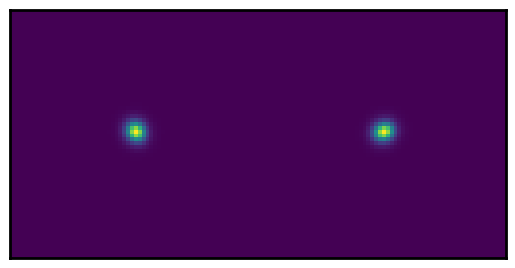

In [3]:
plt.imshow(gal_array, origin="lower")
plt.xticks([])
plt.yticks([])

In [4]:
# Force detections at the centers
indx = np.arange(npix // 2, npix * 2, npix)
indy = np.arange(npix // 2, npix, npix)
ns = len(indx) * len(indy)
inds = np.meshgrid(indy, indx, indexing="ij")
yx = np.vstack([np.ravel(_) for _ in inds])
dtype = np.dtype(
    [
        ("y", np.int32),
        ("x", np.int32),
        ("is_peak", np.int32),
        ("mask_value", np.int32),
    ]
)
detection = np.empty(ns, dtype=dtype)
detection["y"] = yx[0]
detection["x"] = yx[1]
detection["is_peak"] = np.ones(ns)
detection["mask_value"] = np.zeros(ns)

In [5]:
# Do measurement
fpfs_config = anacal.fpfs.FpfsConfig(
    sigma_arcsec=0.52,  # The first measurement scale (also for detection)
    sigma_arcsec2=0.45,  # The second measurement scale
)
catalog = anacal.fpfs.process_image(
    fpfs_config=fpfs_config,
    mag_zero=30.0,
    gal_array=gal_array,
    psf_array=psf_array,
    pixel_scale=pixel_scale,
    noise_variance=max(noise_variance, 0.23),
    noise_array=noise_array,
    detection=detection,
)

e1 = catalog["w"] * catalog["e1"]
e1g1 = catalog["w_g1"] * catalog["e1"] + catalog["w"] * catalog["e1_g1"]

mbias = np.sum(e1) / np.sum(e1g1) / 0.02 - 1  # 0.02 is the input shear

In [6]:
print("Multiplicative bias is: ", mbias)

Multiplicative bias is:  -7.1682146061125e-05
